In [1]:
from importdata import data
from fft import *
from mobility import *
from permutationentropy import *
from utils import *
from lempelziv import *
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from parameters import *

import matplotlib.pyplot as plt


The BIS data is universally longer than the corresponding EEG data. 
It is assumed that the recording of the BIS data continued after the recording of the EEG data has stopped.
This cell trims the BIS data accordingly.

In [2]:
for case in data:
    eeg_duration = case['EEG'].shape[1]/sampling_rate
    print(eeg_duration)
    bis_duration = case['bis'].shape[1]/bis_sampling_rate
    print(bis_duration)
    difference = bis_duration - eeg_duration
    trim_length = int(round(difference * bis_sampling_rate))
    case['bis'] = case['bis'][:, :trim_length + 1]
    bis_duration = case['bis'].shape[1]/bis_sampling_rate
    print(bis_duration)



3760.8125
3835.0
80.0
4888.0
5010.0
125.0
13071.5
13380.0
315.0
3898.75
4010.0
115.0
2419.75
2490.0
75.0
5026.5
5175.0
155.0
6054.75
6205.0
155.0
7949.75
8145.0
200.0
5977.90625
6125.0
150.0
6199.75
6365.0
170.0
13414.0
13750.0
340.0
20338.25
20865.0
530.0
4090.15625
4170.0
85.0
3117.4140625
3205.0
95.0
13180.25
13505.0
330.0
7170.0
7340.0
175.0
7598.75
7785.0
190.0
3705.75
3800.0
100.0
4355.0
4530.0
180.0
9749.65625
9985.0
240.0
9357.5
9590.0
235.0
2314.0
2380.0
70.0
5821.75
5980.0
165.0
3778.5
3875.0
100.0


In [3]:
train_data = data[::2] #select every second case for training
test_data = data[1::2] #select every other case for testing

    
eeg_train_data = [case['EEG'] for case in train_data]
bis_train_data = [case['bis'] for case in train_data]

eeg_test_data = [case['EEG'] for case in test_data]
bis_test_data = [case['bis'] for case in train_data]

signal_lengths = [len(case[0]) for case in eeg_train_data] 


In [4]:
count = 0
for case in train_data:
    for value in case['bis'][0]:
        count += 1

print(count)


460


In [5]:
decomposed_eeg_train_data = [fft(case, sampling_rate) for case in eeg_train_data] #returns an array where each element represents a case and each case is a dictionary where the keys are frequency bands and the values are in the frequency domain
decomposed_eeg_train_time_domain = convert_decomposed_to_time_domain(decomposed_eeg_train_data) #the same as above except the values are in the time domain
decomposed_eeg_train_time_domain_power = convert_decomposed_amplitude_to_power(decomposed_eeg_train_time_domain) #the same as above except the values represent power rather than amplitude

decomposed_eeg_test_data = [fft(case, sampling_rate) for case in eeg_test_data]
decomposed_eeg_test_time_domain = convert_decomposed_to_time_domain(decomposed_eeg_test_data)
decomposed_eeg_test_time_domain_power = convert_decomposed_amplitude_to_power(decomposed_eeg_test_time_domain)

In [6]:
mobility_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_amplitude_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

mobility_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, calculate_mobility, sampling_rate, signal_lengths, mobility_window_duration, mobility_overlap_fraction)
pe_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, PE, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)
lzc_power_array_train = operation_on_multiple_case_data(decomposed_eeg_train_time_domain_power, LZC_single_band, sampling_rate, signal_lengths, complexity_features_window, complexity_features_overlap)

In [7]:
mobility_amplitude_bis_train_dict = associate_features_with_BIS(mobility_amplitude_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_amplitude_train_r2 = linear_regression(mobility_amplitude_bis_train_dict)
print(mobility_amplitude_train_r2)

mobility_power_bis_train_dict = associate_features_with_BIS(mobility_power_array_train, bis_train_data, mobility_window_duration, mobility_overlap_fraction, bis_sampling_rate)
mobility_power_train_r2 = linear_regression(mobility_power_bis_train_dict)
print(mobility_power_train_r2)

pe_amplitude_bis_train_dict = associate_features_with_BIS(pe_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_amplitude_train_r2 = linear_regression(pe_amplitude_bis_train_dict)
print(pe_amplitude_train_r2)

pe_power_bis_train_dict = associate_features_with_BIS(pe_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
pe_power_train_r2 = linear_regression(pe_power_bis_train_dict)
print(f'pe power train r2 {pe_power_train_r2}')

lzc_amplitude_bis_train_dict = associate_features_with_BIS(lzc_amplitude_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_amplitude_train_r2 = linear_regression(lzc_amplitude_bis_train_dict)
print(f'lzc amplitude train r2 {lzc_amplitude_train_r2}')

lzc_power_bis_train_dict = associate_features_with_BIS(lzc_power_array_train, bis_train_data, complexity_features_window, complexity_features_overlap, bis_sampling_rate)
lzc_power_train_r2 = linear_regression(lzc_power_bis_train_dict)
print(f'lzc power train r2 {lzc_power_train_r2}')



Delta
Coefficient: [30.1424115]
Intercept: 66.66518883835012
Theta
Coefficient: [35.76518779]
Intercept: 62.5023757581136
Alpha
Coefficient: [171.32885417]
Intercept: -33.58553602734709
Beta
Coefficient: [-197.64655706]
Intercept: 223.0324297879178
Gamma
Coefficient: [-349.77805594]
Intercept: 333.91553778554464
Beta b
Coefficient: [133.04922568]
Intercept: -6.993657047724909
Gamma 1
Coefficient: [-55.73735197]
Intercept: 127.43124234157264
Gamma 2
Coefficient: [165.61090271]
Intercept: -29.215207630749546
Gamma 3
Coefficient: [183.47520969]
Intercept: -40.25995414043342
Gamma 4
Coefficient: [-113.02927799]
Intercept: 167.75542116962137
Gamma a
Coefficient: [194.32161644]
Intercept: -46.53768112547024
Gamma b
Coefficient: [175.06623735]
Intercept: -32.48134463093183
Beta a
Coefficient: [54.84733423]
Intercept: 48.92249727958874
Alpha a
Coefficient: [97.35088665]
Intercept: 17.062877594027995
Alpha b
Coefficient: [174.06043499]
Intercept: -36.78887600017616
Beta 1
Coefficient: [95.01848

Text(0.5, 1.0, 'Mobility')

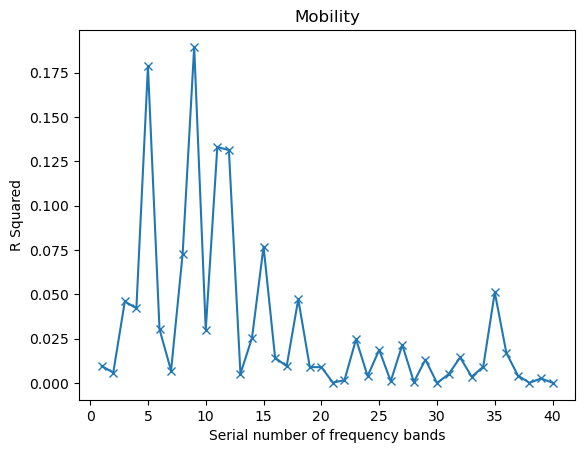

In [8]:
r2_mobility = list(mobility_amplitude_train_r2.values()) + list(mobility_power_train_r2.values())
frequency_bands_mobility = list(range(1, len(r2_mobility) + 1))

plt.plot(frequency_bands_mobility, r2_mobility, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Mobility")





Text(0.5, 1.0, 'Permutation Entropy')

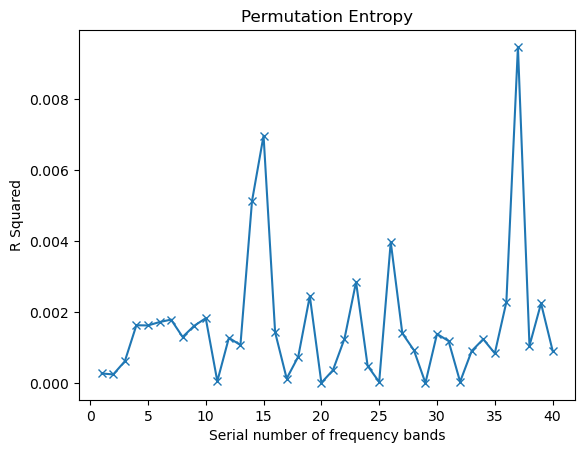

In [9]:
r2_pe = list(pe_amplitude_train_r2.values()) + list(pe_power_train_r2.values())
frequency_bands_pe = list(range(1, len(r2_pe) + 1))

plt.plot(frequency_bands_pe, r2_pe, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Permutation Entropy")

Text(0.5, 1.0, 'Lempel-Ziv Complexity')

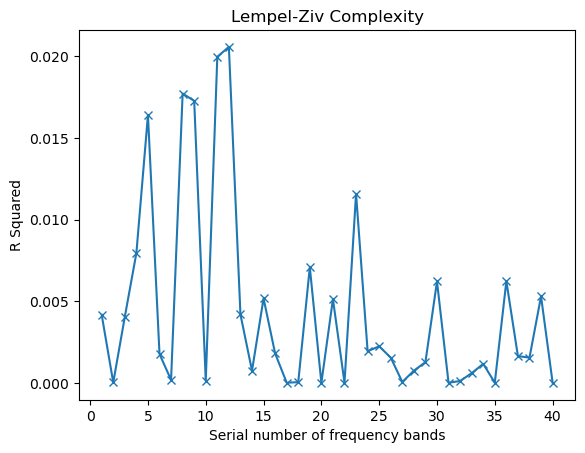

In [10]:
r2_lzc = list(lzc_amplitude_train_r2.values()) + list(lzc_power_train_r2.values())
frequency_bands_lzc = list(range(1, len(r2_lzc) + 1))

plt.plot(frequency_bands_lzc, r2_lzc, marker = 'x')

plt.xlabel("Serial number of frequency bands")
plt.ylabel("R Squared")
plt.title("Lempel-Ziv Complexity")